# **Fusion Classification**

In [ ]:
!unzip '/content/drive/MyDrive/DL_Project_Data/UCF50.zip'

In [39]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception, preprocess_input  
import matplotlib.pyplot as plt
from keras import backend as K
from tabulate import tabulate
from tensorflow import keras
from imutils import paths
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import pickle 
import shutil
import cv2
import os
import os

In [ ]:
def update_files(DIR):
    classes = sorted(os.listdir(DIR))
    classes.remove('BaseballPitch')

    for each_class in classes:
        class_path = os.path.join(DIR, each_class)
        videos = sorted(os.listdir(class_path))

        video_files = []
        for i in range(1, 26):
            if i < 10: padded_num = str(i).zfill(2)
            else: padded_num = str(i)

            video_files.append('v_{}_g{}_c01.avi'.format(each_class, padded_num))

        # Loop through all files in the directory
        for filename in videos:
            if filename not in video_files:
                os.remove(os.path.join(class_path, filename))

    return 'Done'

In [ ]:
DIR = '/content/UCF50'
update_files(DIR)

'Done'

In [4]:
dataset_path = os.listdir('/content/content/UCF50')
label_types = os.listdir('/content/content/UCF50')
print(label_types) 

['Biking', 'JavelinThrow', 'CleanAndJerk', 'YoYo', 'HighJump', 'WalkingWithDog', 'Skiing', 'Diving', 'Swing', 'SkateBoarding', 'BreastStroke', 'Kayaking', 'BaseballPitch', 'ThrowDiscus', 'PlayingTabla', 'VolleyballSpiking', 'HulaHoop', 'PommelHorse', 'BenchPress', 'SalsaSpin', 'Lunges', 'RockClimbingIndoor', 'PushUps', 'JumpingJack', 'Nunchucks', 'Skijet', 'Billiards', 'PlayingPiano', 'PlayingGuitar', 'JugglingBalls', 'PizzaTossing', 'PoleVault', 'Drumming', 'HorseRace', 'RopeClimbing', 'PlayingViolin', 'SoccerJuggling', 'Fencing', 'PullUps', 'Punch', 'Basketball', 'TennisSwing', 'Rowing', 'JumpRope', 'GolfSwing', 'MilitaryParade', 'TaiChi', 'TrampolineJumping', 'HorseRiding', 'Mixing']


In [5]:
# creating the dataset
DIR = '/content/content/UCF50'
data = []

for category in dataset_path:
    category_path = os.path.join(DIR, category)
    class_folder = os.listdir(category_path)

    for each_video in class_folder:
        video_path = os.path.join(category_path, each_video)
        data.append((category, video_path))
    
# Build a dataframe        
main_df = pd.DataFrame(data=data, columns=['tag', 'video_name'])
main_df.shape

(1200, 2)

In [6]:
main_df.head()

,tag,video_name
0,Biking,/content/content/UCF50/Biking/v_Biking_g08_c01...
1,Biking,/content/content/UCF50/Biking/v_Biking_g15_c01...
2,Biking,/content/content/UCF50/Biking/v_Biking_g07_c01...
3,Biking,/content/content/UCF50/Biking/v_Biking_g12_c01...
4,Biking,/content/content/UCF50/Biking/v_Biking_g23_c01...


In [7]:
train, val = train_test_split(main_df, test_size=0.2, stratify=main_df['tag'])
val, test = train_test_split(val, test_size=0.5, stratify=val['tag'])

print(f"{train.shape}, {test.shape}, {val.shape}")

(960, 2), (120, 2), (120, 2)


In [8]:
train.to_csv('train.csv')
test.to_csv('test.csv')
val.to_csv('val.csv')

In [9]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
val = pd.read_csv('/content/val.csv')

In [10]:
train.shape

(960, 3)

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

In [12]:
IMG_SIZE = 224

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
        
    return np.array(frames)

In [13]:
frames = load_video('/content/content/UCF50/BaseballPitch/v_BaseballPitch_g01_c01.avi')
frames.shape

(107, 224, 224, 3)

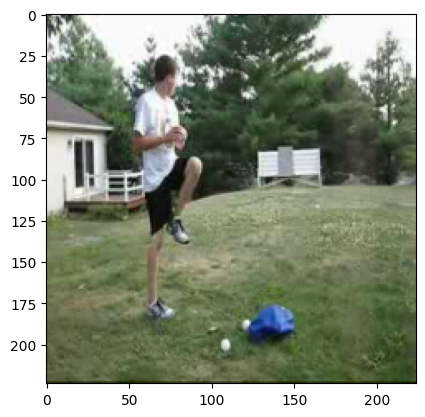

In [14]:
plt.imshow(frames[50])

In [15]:
def build_feature_extractor():
    feature_extractor = Xception(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [16]:
feature_extractor = build_feature_extractor()

83683744/83683744 [==============================] - 5s 0us/step


In [17]:
image = frames[50]
image = image.reshape((-1, 224, 224, 3))
ans = feature_extractor.predict(image, verbose=0)
ans.shape

(1, 2048)

In [18]:
ans

array([[0.20089838, 0.06411196, 0.        , ..., 0.14567336, 0.        ,
        0.02910281]], dtype=float32)

In [19]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary = np.unique(train["tag"]))
print(label_processor.get_vocabulary())

['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpRope', 'JumpingJack', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']


In [21]:
labels = train["tag"].values
labels = label_processor(labels[..., None]).numpy()

In [22]:
# Define hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [23]:
def prepare_all_videos(df, root_dir):
    num_samples, video_paths = len(df), df["video_name"].values.tolist()
    
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # For each video.
    for idx, path in enumerate(video_paths):
        video_path = os.path.join(root_dir, path)
        frames = load_video(video_path)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(1, MAX_SEQ_LENGTH,), 
            dtype="bool"
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), 
            dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :],
                    verbose=0
                )
            temp_frame_mask[i, :length] = 1

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [24]:
train_data, train_labels = prepare_all_videos(train, "train")
validation_data, validation_labels = prepare_all_videos(val, "val")
test_data, test_labels = prepare_all_videos(test, "test")

In [25]:
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"train_labels in train set: {train_labels.shape}")

Frame features in train set: (960, 20, 2048)
Frame masks in train set: (960, 20)
train_labels in train set: (960, 1)


In [26]:
print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")
print(f"test_labels in test set: {test_labels.shape}")

Frame features in test set: (120, 20, 2048)
Frame masks in test set: (120, 20)
test_labels in test set: (120, 1)


In [27]:
print(f"Frame features in validation set: {validation_data[0].shape}")
print(f"Frame masks in validation set: {validation_data[1].shape}")
print(f"validation_labels in validation set: {validation_labels.shape}")

Frame features in validation set: (120, 20, 2048)
Frame masks in validation set: (120, 20)
validation_labels in validation set: (120, 1)


# **Saving the Extracted Feature Data files**

In [29]:
with open('/content/drive/MyDrive/Final_Deliveries/train/xception_train_data.pkl', 'wb') as file:
    pickle.dump(train_data, file)

with open('/content/drive/MyDrive/Final_Deliveries/train/xception_train_labels.pkl', 'wb') as file:
    pickle.dump(train_labels, file)

In [30]:
with open('/content/drive/MyDrive/Final_Deliveries/test/xception_test_data.pkl', 'wb') as file:
    pickle.dump(test_data, file)

with open('/content/drive/MyDrive/Final_Deliveries/test/xception_test_labels.pkl', 'wb') as file:
    pickle.dump(test_labels, file)

In [31]:
with open('/content/drive/MyDrive/Final_Deliveries/val/xception_val_data.pkl', 'wb') as file:
    pickle.dump(validation_data, file)

with open('/content/drive/MyDrive/Final_Deliveries/val/xception_val_labels.pkl', 'wb') as file:
    pickle.dump(validation_labels, file)

# **BiLSTM Model**

In [ ]:
with open('/content/drive/MyDrive/DL_Project_Data/train/xception_train_data.pkl', 'rb') as file:
    train_data = pickle.load(file)

with open('/content/drive/MyDrive/DL_Project_Data/train/xception_train_labels.pkl', 'rb') as file:
    train_labels = pickle.load(file)

with open('/content/drive/MyDrive/DL_Project_Data/test/xception_test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)

with open('/content/drive/MyDrive/DL_Project_Data/test/xception_test_labels.pkl', 'rb') as file:
    test_labels = pickle.load(file)

with open('/content/drive/MyDrive/DL_Project_Data/val/xception_val_data.pkl', 'rb') as file:
    validation_data = pickle.load(file)

with open('/content/drive/MyDrive/DL_Project_Data/val/xception_val_labels.pkl', 'rb') as file:
    validation_labels = pickle.load(file)

In [32]:
EPOCHS = 2000

In [33]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True))(frame_features_input, mask=mask_input)
    x = keras.layers.Concatenate()([frame_features_input, x])
    x = keras.layers.Bidirectional(keras.layers.GRU(32))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)
    bilstm = keras.Model([frame_features_input, mask_input], output)

    bilstm.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer="adam", 
        metrics=['accuracy']
    )
    return bilstm

In [34]:
def run_experiment():
    filepath = "/content/drive/MyDrive/Final_Deliveries/xception_plus_bilstm/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_data=([validation_data[0], validation_data[1]], validation_labels),
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test Accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

history, sequence_model = run_experiment()

Streaming output truncated to the last 5000 lines.
Epoch 751: val_loss did not improve from 2.20610
30/30 [==============================] - 1s 26ms/step - loss: 0.0063 - accuracy: 0.9979 - val_loss: 6.3769 - val_accuracy: 0.5250
Epoch 752/2000
28/30 [===========================>..] - ETA: 0s - loss: 0.0053 - accuracy: 0.9989
Epoch 752: val_loss did not improve from 2.20610
30/30 [==============================] - 1s 25ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 6.2342 - val_accuracy: 0.5167
Epoch 753/2000
30/30 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000
Epoch 753: val_loss did not improve from 2.20610
30/30 [==============================] - 1s 26ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 6.3477 - val_accuracy: 0.5333
Epoch 754/2000
30/30 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9979
Epoch 754: val_loss did not improve from 2.20610
30/30 [==============================] - 1s 31ms/step - loss: 0.0097 

In [35]:
sequence_model.evaluate([test_data[0], test_data[1]], test_labels)

4/4 [==============================] - 0s 14ms/step - loss: 2.2410 - accuracy: 0.5417


[2.240962266921997, 0.5416666865348816]

In [36]:
def train_val_plot(acc, val_acc, loss, val_loss):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20,5))
  fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

  ax1.plot(range(1, len(acc) + 1), acc)
  ax1.plot(range(1, len(val_acc) + 1), val_acc)
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['Training', 'Validation'])

  ax2.plot(range(1, len(loss) + 1), loss)
  ax2.plot(range(1, len(val_loss) + 1), val_loss)
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['Training', 'Validation'])
  plt.show()

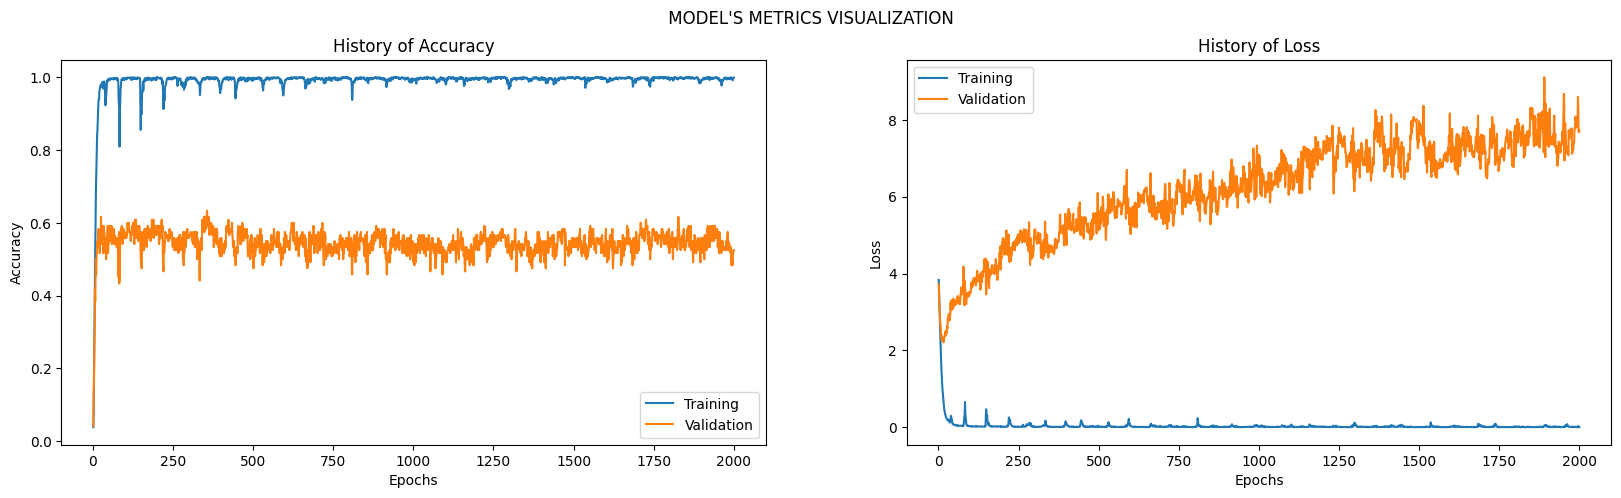

In [37]:
train_val_plot(
    history.history['accuracy'], history.history['val_accuracy'],
    history.history['loss'], history.history['val_loss'],
)

In [ ]:
sequence_model.save('/content/drive/MyDrive/Final_Deliveries/xception_plus_bilstm')

In [43]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/Final_Deliveries/xception_plus_bilstm.csv')
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,3.831593,0.038542,3.718561,0.041667
1,3.557408,0.077083,3.406024,0.125000
2,3.240403,0.159375,3.202624,0.166667
3,2.911030,0.271875,3.027876,0.233333
4,2.663415,0.333333,2.849072,0.291667


# **Inference (Test on Video)**

In [41]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :], verbose=0)
        frame_mask[i, :length] = 1

    return frame_features, frame_mask

def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()
    
    output = [['Class', 'Percentage of Belonging (in %)']]
    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask], verbose=0)[0]

    print("Probabilities of Each Class: \n")
    for i in np.argsort(probabilities)[::-1]:
        output.append([class_vocab[i], probabilities[i] * 100])
        # print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

    print(tabulate(output, headers='firstrow', tablefmt='github'))
    return frames

test_video = np.random.choice(test["video_name"].values.tolist())
print(f"Test video path: {test_video}\n")
test_frames = sequence_prediction(test_video)

Test video path: /content/content/UCF50/HighJump/v_HighJump_g07_c01.avi

Probabilities of Each Class: 

| Class              |   Percentage of Belonging (in %) |
|--------------------|----------------------------------|
| HighJump           |                     18.9786      |
| GolfSwing          |                     16.1947      |
| SoccerJuggling     |                     14.257       |
| JavelinThrow       |                     12.8108      |
| JumpRope           |                     12.5483      |
| HorseRace          |                      6.56858     |
| BaseballPitch      |                      4.70326     |
| RopeClimbing       |                      2.12034     |
| Biking             |                      1.93494     |
| SalsaSpin          |                      1.90804     |
| Nunchucks          |                      1.03496     |
| PoleVault          |                      0.919339    |
| TrampolineJumping  |                      0.903917    |
| TaiChi             |    